# Fine-tuning to follow instructions
## Prepare dataset for supervised instruction fine-tuning

In [1]:
import os, json, urllib, torch

def download_and_load_file(file_path, url):
    # compose .json file
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    # read .json file to get <data>
    with open(file_path, "r") as file:
        data = json.load(file)
    return data
        
file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
# Print 1 entry to test 
# => {instruction:"", input:"", output:""}
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### Convert "data" to Alpaca-style prompt format

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [5]:
# In this case the field "input" is missing
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


### Partioning the data in to train/val/test

In [6]:
train_portion = int(len(data)*0.85)
test_portion = int(len(data)*0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:", len(train_data)) # 85%
print("Validation set length:", len(val_data)) # 5%
print("Test set length:", len(test_data)) # 10%

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

In [7]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    # data: list of {'instruction': 'Identify...', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
    def __init__(self, data, tokenizer):
        self.data = data 
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            # list of e.g [23,1,244,...]/[2,456,..]/; each is encoded conversation text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
            
    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)
    

In [8]:
# Check id of the padding <|endoftext|> token
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [9]:
# Padding to the longest length IN THE BATCH ONLY
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch) # max length of each prompt PLUS 1
    
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id]*(batch_max_length-len(new_item)) # even the longest prompt with be padded with <50256>
        inputs = torch.tensor(padded[:-1]) # last <50256> token removed => tensor of (max_len,)
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device) # (batch,max_len)
    return inputs_tensor

inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]
batch = (inputs_1, inputs_2, inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [10]:
# Create TARGET TOKEN IDs
# which is input-token-ids shifted by 1 to the left; then a PADDING-TOKEN at the end
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch) # max length of each prompt PLUS 1
    
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id]*(batch_max_length-len(new_item)) # even the longest prompt will be padded with <50256>
        inputs = torch.tensor(padded[:-1]) # last <50256> token removed => tensor of (max_len,)
        targets = torch.tensor(padded[1:]) # old sentence shifted left, then an additional <50256> on the right => tensor of (max_len,)
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device) # (batch,max_len)
    targets_tensor = torch.stack(targets_lst).to(device) # (batch,max_len)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [11]:
# Replace padding tokens IN TARGET tensor with <-100> tokens (EXCEPT the EndOfLine)
# batch_max_length: length of the longest sentence in that batch
# allowed_max_length: if a sentence is longer than e.g. 1024 tokens => trim it down
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch) # max length of each sentence PLUS 1
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = new_item + [pad_token_id]*(batch_max_length-len(new_item)) # even the longest prompt will be padded with <50256>
        inputs = torch.tensor(padded[:-1]) # last <50256> token removed => tensor of (max_len,)
        targets = torch.tensor(padded[1:]) # old sentence shifted left, then an additional <50256> on the right => tensor of (max_len,)

        mask = targets == pad_token_id # (max_len,) of bools; True where <50256>s are
        # location of nonzero locations (num_nonzeros,1) => squeeze to (num_nonzeros,); each is index location
        indices = torch.nonzero(mask).squeeze() 
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index # change every last indices to -100 except one

        # trim down too long sentences
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs) # (batch,max_len)
        targets_lst.append(targets) # (batch,max_len)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [12]:
# To demonstrate that <-100> IN TARGET completely ignores the 3rd (padding) token IN INPUT
# logits of 2 predictions of 2 tokens (row1=prediction for token1)
logits_1 = torch.tensor(
    [[-1,1.0],
     [-0.5,1.5]]
)
targets_1 = torch.tensor([0,1]) # int-label for 2 tokens
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print("Loss of predicting 2 tokens:", loss_1)

# predictions of 3 tokens
logits_2 = torch.tensor(
    [[-1.0, 1.0],
    [-0.5, 1.5],
    [-0.5, 1.5]]
)
targets_2 = torch.tensor([0,1,1]) # int-label
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print("Loss of predicting 3 tokens:", loss_2)

# predictions of 3 tokens but with 3rd token ignored by target (setting 3rd label to -100)
targets_3 = torch.tensor([0,1,-100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print("Loss of predicting 3 tokens with 3rd label=-100:", loss_3)


Loss of predicting 2 tokens: tensor(1.1269)
Loss of predicting 3 tokens: tensor(0.7936)
Loss of predicting 3 tokens with 3rd label=-100: tensor(1.1269)


## Create dataloaders for instruction dataset

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [14]:
# dataset now is through <collate_fn> WITH PARAMS <device> & <allowed_max_length>
# => we must use <partial>
from functools import partial
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [15]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape) # (8,n_tokens), (8,n_tokens)

Train loader:


/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 1030 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GT 1030 with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the NVIDIA GeForce GT 1030 GPU with PyTorch

torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.Size([8, 68])


## Loading a pretrained LLM

In [16]:
from gpt_download import download_and_load_gpt2
import torch.nn as nn
import numpy as np

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # optional trainable params
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
  
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # (batch,1)
        # biased variance: divided by 1/(n-1)
        # unbiased variance: divided by 1/n
        var = x.var(dim=-1, keepdim=True, unbiased=False) # (batch,1)
        norm_x = (x-mean) / torch.sqrt(var+self.eps) # (batch,emb_dim)
        return self.scale * norm_x + self.shift # (batch,emb_dim)
        
class GeLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh( torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3)) ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
          GeLU(),
          nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
  
    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out # 4
        self.num_heads = num_heads # 2
        self.head_dim = d_out // num_heads # 2

        # bigger weight matrices
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias) # (3,4)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # compute big kqv matrices
        keys = self.W_key(x) # (b,n,3)=>(b,n_token,4)
        queries = self.W_query(x) # (b,n,3)=>(b,n_token,4)
        values = self.W_value(x) # (b,n,3)=>(b,n_token,4)
        # ... then splits
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head=2,head_dim=2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head,head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) # (b,n_token,n_head,head_dim)
        # swap <num_heads> to after-batch location
        keys = keys.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)
        queries = queries.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)
        values = values.transpose(1,2) # (b,n_head=2,n_token,head_dim=2)

        attn_scores = queries @ keys.transpose(2,3) # (b,n_head,n_token,head_dim)@(b,n_head,head_dim,n_token)=>(b,n_head,n_token,n_token)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf) # (n,n) with upper-right is -inf
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights) # (b,n_head,n_token,n_token)

        context_vec = (attn_weights @ values).transpose(1,2) # (b,n_head,n_token,head_dim=2)=>transpose to (b,n_token,n_head,head_dim=2)
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out) # (b,n_token,n_head*head_dim)=(b,n_token,4)
        context_vec = self.out_proj(context_vec) # (b,n_token,4)

        return context_vec # (b,n_token,4)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        return x 

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # in_idx: (batch,seq_len), each element is a token-index (integer shows location)
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) # (batch,seq_len)=>(batch,seq_len,emb_dim)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (1,seq_len)=>(1,seq_len,emb_dim)
        x = tok_embeds + pos_embeds # (batch,seq_len,emb_dim)
        x = self.drop_emb(x) # (batch,seq_len,emb_dim)
        x = self.trf_blocks(x) # (batch,seq_len,emb_dim)
        x = self.final_norm(x) # (batch,seq_len,emb_dim)
        logits = self.out_head(x) # (batch,seq_len,vocab_len)
        return logits

# small utils function: check if <left> and <right> has matching shape
# if yes then return <Parameter> as the right tensor
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    # load positional encoding
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    # load token embedding
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    # load transformers blocks
    for b in range(len(params["blocks"])):
        # params["blocks"][b]["attn"]: <multi-head-attn> part
        # <multi-head-attn>["c_attn"]: convolution attention (of qkv) inside
        # split to 3 parts <query>,<key>,<value>
        q_w, k_w, v_w = np.split( params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1) # each (768,768)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # bias of <attn> in <multi-head-attention>
        q_b, k_b, v_b = np.split( params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1) # each (768,)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        # out-projection of <attn> in <multi-head-attention>
        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

        # feed-forward; layer0 & layer1 (layer1 is GeLU)
        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        # layer normalization
        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    # Final layer normalization
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    # Out weight
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) # we use the token embedding weights again ("weight tying")

2025-12-11 08:53:48.177197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/phm1605/anaconda3/envs/python310/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility viola

In [17]:
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12, "n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024, "n_layers":24, "n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280, "n_layers":36, "n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600, "n_layers":48, "n_heads":25}
}
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")") # 355M
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|███████████████████████████| 77.0/77.0 [00:00<00:00, 88.8kiB/s]
encoder.json: 100%|████████████████████████| 1.04M/1.04M [00:09<00:00, 111kiB/s]
hparams.json: 100%|██████████████████████████| 91.0/91.0 [00:00<00:00, 110kiB/s]
model.ckpt.data-00000-of-00001: 100%|█████| 1.42G/1.42G [14:12<00:00, 1.66MiB/s]
model.ckpt.index: 100%|███████████████████| 10.4k/10.4k [00:00<00:00, 9.46MiB/s]
model.ckpt.meta: 100%|███████████████████████| 927k/927k [00:01<00:00, 658kiB/s]
vocab.bpe: 100%|█████████████████████████████| 456k/456k [00:00<00:00, 491kiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GeLU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [18]:
# Try to load a conversation from val dataset
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [19]:
import tiktoken

## Text generation with temperature scaling & top-k & multinomial-sampling
# idx: (batch,seq_len) with batch=1 for now
# eos_id: stop generating when we generate the char <eos_id>
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # crop if sentence too long
        with torch.no_grad():
            logits = model(idx_cond) # (1,seq_len,vocab_len)
        # take last token in predicted sequence
        logits = logits[:,-1,:] # (1,vocab_len)
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            # change outside-top3 logits to "-inf"
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        # temperature scaling
        if temperature > 0.0:
            logits = logits/temperature # (1,vocab_len)
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else: 
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) # (1,1)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1) # (batch,seq_len+1)
    return idx # (batch, seq_len+num_new_tokens)
            
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # (n_tokens,)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # (1,n_tokens)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # (n_tokens,)
    return tokenizer.decode(flat.tolist())

In [20]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)
generated_text = token_ids_to_text(token_ids, tokenizer)
# Crop the input part, show only the generated part
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Fine tuning LLM on instruction data

In [24]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device) # (batch,n_token)
    logits = model(input_batch) # (batch,n_token,embed_dim)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0] # 256
    encoded = text_to_token_ids(start_context, tokenizer).to(device) # (batch,n_tokens)
    with torch.no_grad():
        # token_ids: (batch, n_tokens+50)
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# eval_iter: is NUM_BATCHES in evaluate (how many batches we want to evaluate)
# start_context: sentence we evaluate the performance of model on
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], [] 
    # <tokens_seen>: every time we runs through a batch of (batch,n_tokens), we add up <batch*n_tokens>
    # global_step: add up after every <batch_size> = 2 samples
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step() # update weights
            # optional steps
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx: (batch, n_tokens_long)
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] # take last <context_size> tokens as context => (batch,context_size)
        with torch.no_grad():
            logits = model(idx_cond) # (batch,context_size,vocab_len)
        logits = logits[:,-1,:] # last tokenS - (batch,vocab_len)
        probas = torch.softmax(logits,dim=-1) # (batch,vocab_len)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (batch,1)
        idx = torch.cat((idx, idx_next), dim=1) #(batch,n_tokens_long+1)
    return idx

In [25]:
# Calculate initial loss for training and validation set
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 0.47062680721282957
Validation loss: 0.6655189871788025


In [26]:
# Fine-tuning
import time 
start_time = time.time()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
# start_context: only <instruction> and <input> fields, no <response>; to validate our model performance over training for that specific text
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 0.508, Val loss 0.677
Epoch 1 (Step 000005): Train loss 0.537, Val loss 0.701
Epoch 1 (Step 000010): Train loss 0.453, Val loss 0.682
Epoch 1 (Step 000015): Train loss 0.533, Val loss 0.682
Epoch 1 (Step 000020): Train loss 0.489, Val loss 0.683
Epoch 1 (Step 000025): Train loss 0.399, Val loss 0.683
Epoch 1 (Step 000030): Train loss 0.448, Val loss 0.677
Epoch 1 (Step 000035): Train loss 0.483, Val loss 0.673
Epoch 1 (Step 000040): Train loss 0.414, Val loss 0.672
Epoch 1 (Step 000045): Train loss 0.408, Val loss 0.674
Epoch 1 (Step 000050): Train loss 0.421, Val loss 0.670
Epoch 1 (Step 000055): Train loss 0.462, Val loss 0.673
Epoch 1 (Step 000060): Train loss 0.381, Val loss 0.682
Epoch 1 (Step 000065): Train loss 0.450, Val loss 0.676
Epoch 1 (Step 000070): Train loss 0.374, Val loss 0.684
Epoch 1 (Step 000075): Train loss 0.410, Val loss 0.693
Epoch 1 (Step 000080): Train loss 0.377, Val loss 0.683
Epoch 1 (Step 000085): Train loss 0.368, Val los

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # 2nd x-axis that shares same y-axis
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    
    fig.tight_layout()
    plt.show()

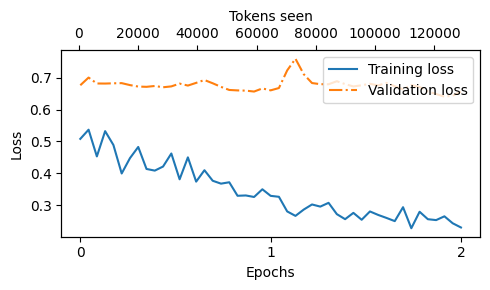

In [28]:
# Plot losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


## Extract and save responses

In [32]:
# Print model generated and target
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    ) # (1,62) - break at <eos>
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------")
    

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus.
-------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Aust

In [34]:
# Save response to "instruction-data-with-response.json"
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    ) # (1,n_tokens_response)
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    test_data[i]["model_response"] = response_text

# save to json file
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)


100%|█████████████████████████████████████████| 110/110 [01:18<00:00,  1.40it/s]


In [35]:
# verify 1 new test sample with response
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [37]:
# Save model
import re
# remove ' ' and '[]'
file_name = f"{re.sub(r'[ ()]','',CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name) # gpt2-medium355M-sft.pth

In [38]:
# Load model
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

<All keys matched successfully>

## Evaluating the fine-tuned LLM against a standard LLM e.g. Llama3 model
### - install Ollama first
curl -fsSL https://ollama.com/install.sh | sh
### - run llama3
ollama run llama3

In [41]:
# Check if Ollama is running
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
    
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", ollama_running)

Ollama running: True


In [43]:
# Interact with Ollama via RestAPI using Python
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # create data payload as a dictionary
    data = {
        "model": model,
        "messages": [{"role":"user", "content":prompt}],
        "options": {"seed":123, "temperature":0, "num_ctx":2048}
    }
    # convert dictionary to json; encode to "utf-8"
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)


Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in many llama diets.
3. Grains: Oats, barley, and corn are common grains that llamas enjoy.
4. Fruits and vegetables: Llamas may also eat fruits like apples, carrots, and sweet potatoes, as well as leafy greens like kale and spinach.
5. Minerals: Llamas need access to minerals like calcium, phosphorus, and salt to maintain strong bones and overall health.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, like willow or cedar.
2. Bark: In some cases, they may eat the bark of certain trees, like aspen or birch.
3. Mosses: Llamas have been known to graze on mosses and other non-woody plant material.

In captivity, llama owners typically provide a bal

In [47]:
# Ask <Ollama> to rate our <generated-text> with our <target>
# test_data[x]=entry: {instruction,input,output,model_response}
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:\n>>", entry['output'])
    print("\nModel response:\n>>", entry['model_response'])
    print("\nScore:\n>>", query_model(prompt))
    print("\n---------------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> I'd rate the model response "The car is as fast as a cheetah." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to that of a cheetah.
* Cheetahs are known for their incredible speed, making them a relevant and effective comparison for describing a fast car.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that lightning is often used as a metaphor for extreme speed, so using a cheetah instead of lightning might not be as universally recognized or evocative. However, the response is still effective and well-written, earning an 85 out of 100.

---------------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderst

In [48]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [51]:
# Evaluate overall model score
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    # entry: {instruction,input,output,model_response}
    for entry in tqdm(json_data, desc="Scoring entries"):
        # NOTE: we ask Ollama to response WITH INTEGER ONLY
        prompt = (
            f"Given the input `{format_input(entry)}` " # a long-text with ### Instruction etc.
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Response with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores
          
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")


Scoring entries:  71%|█████████████████▋       | 78/110 [04:27<02:58,  5.58s/it]

Could not convert score: **Model Response:** Swim: Verb, Beautiful: Adjective, Quickly: Adverb
**Score:** 100


Scoring entries: 100%|████████████████████████| 110/110 [06:13<00:00,  3.39s/it]

Number of scores: 109 of 110
Average score: 48.66



In [54]:
print(test_data[68:80])


[{'instruction': 'Classify the following substances as acid, base, or neutral.', 'input': 'Lemon juice, Soap, Water', 'output': 'Acid: Lemon juice\nBase: Soap\nNeutral: Water', 'model_response': 'Acid: Soap\nBase: Lemon juice\nNeutral: Soap'}, {'instruction': "What is a synonym of 'sad'?", 'input': '', 'output': "A synonym for 'sad' is 'unhappy'.", 'model_response': "A synonym for 'sad' is 'determined'."}, {'instruction': 'Correct any spelling mistakes in the given sentence.', 'input': 'I prefer homemade cookies to store boaght.', 'output': 'I prefer homemade cookies to store bought.', 'model_response': 'I prefer homemade cookies to store stored boaght.'}, {'instruction': "Generate a sentence using the word 'transient'.", 'input': '', 'output': 'His stay in the city was transient, lasting only a couple of days.', 'model_response': 'She is very quick.'}, {'instruction': "Translate 'I am lost' into Italian.", 'input': '', 'output': "The Italian translation of 'I am lost' is 'Mi sono pers